In [3]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU is available for TensorFlow!")
else:
    print("No GPU found for TensorFlow.")


TensorFlow version: 2.18.0
GPU is available for TensorFlow!


In [4]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers # Import layers for augmentation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import os

In [5]:
# Loading the Fashion-MNIST dataset from Keras built-in datasets
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

Train images shape: (60000, 28, 28), Train labels shape: (60000,)
Test images shape: (10000, 28, 28), Test labels shape: (10000,)


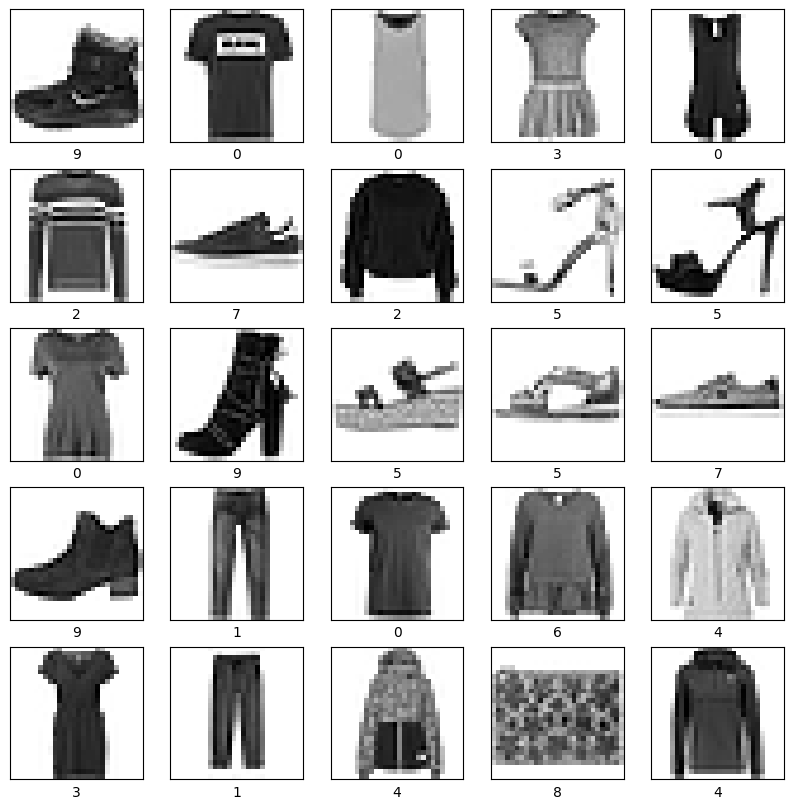

In [6]:
print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")

# seeing a few samples
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()


In [7]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=1
)

print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")

Train images shape: (54000, 28, 28), Train labels shape: (54000,)
Validation images shape: (6000, 28, 28), Validation labels shape: (6000,)
Test images shape: (10000, 28, 28), Test labels shape: (10000,)


In [8]:
# Data Preprocessing
# Normalization
print("Normalizing pixel values from [0, 255] to [0.0, 1.0]")
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

Normalizing pixel values from [0, 255] to [0.0, 1.0]


In [9]:
# Splitting into Training and Validation Sets
# I used `stratify` to ensure that the class distribution in train and validation sets is similar to the original dataset.
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=1, stratify=train_labels
)

print(f"Training images shape: {train_images.shape}, Training labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")


Training images shape: (48600, 28, 28), Training labels shape: (48600,)
Validation images shape: (5400, 28, 28), Validation labels shape: (5400,)
Test images shape: (10000, 28, 28), Test labels shape: (10000,)


In [10]:
# Defining the batch size for training and evaluation
BATCH_SIZE = 64

# Shuffling the training dataset for better generalization.
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"tf.data.Dataset objects created with a batch size of {BATCH_SIZE}.")

tf.data.Dataset objects created with a batch size of 64.


In [11]:
# Data Augmentation
# These layers apply random transformations to images during training only.
# This helps the model generalize better and reduces overfitting by exposing it to more varied versions of the training data.
data_augmentation = Sequential(
    [
        layers.Input(shape=(28, 28, 1)),
        layers.RandomFlip("horizontal"), # Randomly flip images horizontally
        layers.RandomRotation(0.05),     # Randomly rotate images by up to 0.05 * 2*pi radians
        layers.RandomZoom(0.1),          # Randomly zoom in or out by up to 10%
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Randomly shift images by up to 10%
    ],
    name="data_augmentation",
)
print("Data augmentation layers defined.")

Data augmentation layers defined.


In [12]:
# CNN Model Definition
def create_cnn_model(input_shape=(28, 28, 1), num_classes=10):
    model = Sequential([
        # Adding the data augmentation as the first layer. It will only apply during model.fit() (training).
        data_augmentation,

        # First Convolutional Block:
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Second Convolutional Block:
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Third Convolutional Block:
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Flatten Layer:
        # Converts the 3D output of the convolutional layers into a 1D vector so it can be fed into the fully connected (Dense) layers.
        Flatten(),

        # Dense (Fully Connected) Layers:
        Dense(128, activation='relu'),
        # Dropout: Randomly sets a fraction (0.3 = 30%) of neurons to zero during training.
        # This helps prevent overfitting by forcing the network to learn redundant representations.
        Dropout(0.3),
        # Output Dense layer:
        Dense(num_classes, activation='softmax')
    ])
    return model

# Creating an instance of our CNN model
model = create_cnn_model(input_shape=(28, 28, 1))

print("CNN Model Summary:")
model.summary()

CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Model Compilation

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print("Model compiled successfully.")

USE_EARLY_STOPPING = True
callbacks = []
if USE_EARLY_STOPPING:
    print("\nConfiguring Early Stopping callback...")
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',      # Monitoring the validation loss
        patience=8,              # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True, # Restores model weights from the epoch with the best monitored value
        mode='min',              # 'min' means training stops when the monitored quantity stops decreasing
        verbose=1
    )
    callbacks.append(early_stopping_callback)
    print(f"Early Stopping enabled with patience={early_stopping_callback.patience} on '{early_stopping_callback.monitor}'.")
else:
    print("\nEarly Stopping is DISABLED. Model will train for all specified epochs.")

# Model Training
EPOCHS = 25
print(f"\nStarting model training for {EPOCHS} epochs...")
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset)
print("Model training finished.")

# Model Evaluation on Test Set
# Evaluate the model's final performance on the completely unseen test dataset.
print("\nEvaluating model on the test set...")
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"\nFinal Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Model compiled successfully.

Configuring Early Stopping callback...
Early Stopping enabled with patience=8 on 'val_loss'.

Starting model training for 25 epochs...
Epoch 1/25
760/760 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5978 - loss: 1.0739 - val_accuracy: 0.7848 - val_loss: 0.6054
Epoch 2/25
760/760 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7748 - loss: 0.6016 - val_accuracy: 0.8130 - val_loss: 0.5199
Epoch 3/25
760/760 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8034 - loss: 0.5226 - val_accuracy: 0.8298 - val_loss: 0.4603
Epoch 4/25
760/760 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8273 - loss: 0.4654 - val_accuracy: 0.8356 - val_loss: 0.4746
Epoch 5/25
760/760 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8354 - loss: 0.4497 - val_accuracy: 0.8546 - val_loss: 0.3959
Epoch 6/25
760/760 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8470 - loss: 0.4079 - val_accuracy: 0.8480 - val_loss: 0.4225
Epoch 7/25
760/760 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 

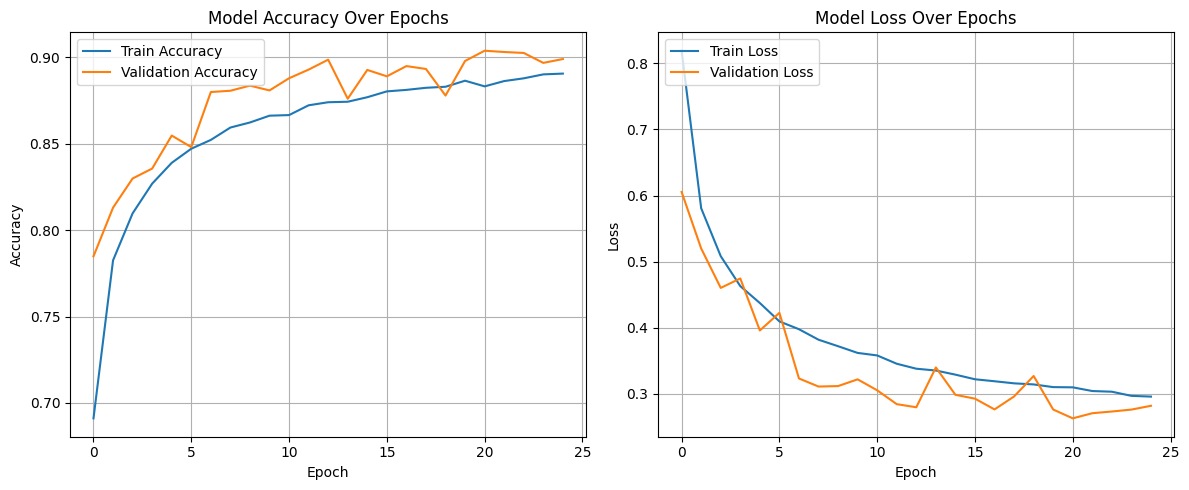

Training history plots displayed.


In [14]:
plt.figure(figsize=(12, 5))

# Plotting the Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

# Plotting the Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()
print("Training history plots displayed.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


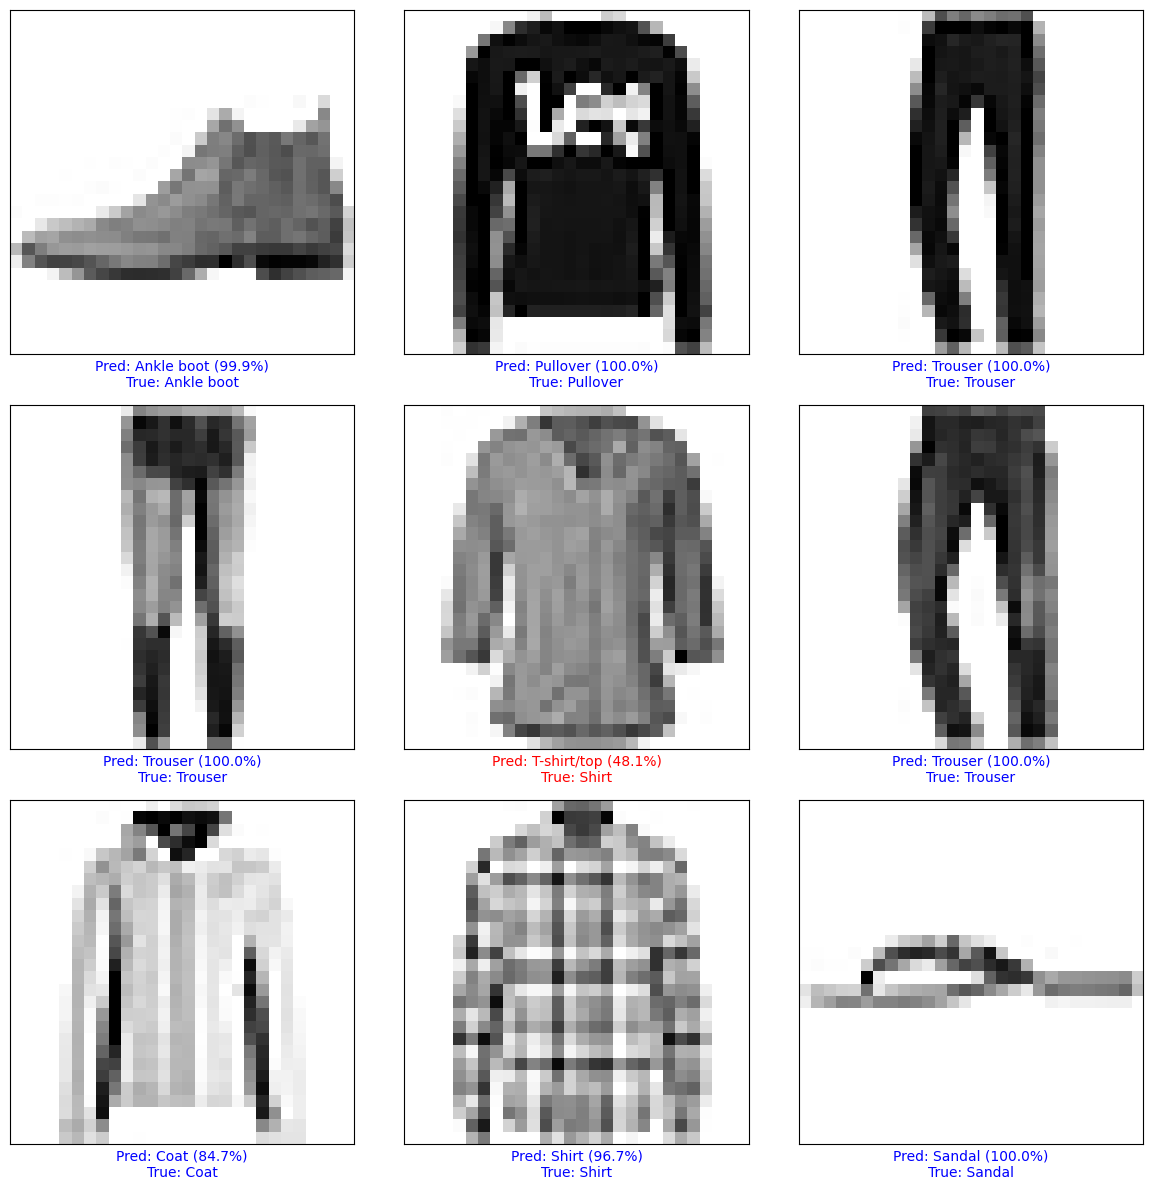

Example predictions displayed.


In [15]:
# Define the class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

num_images_to_show = 9

for images, labels in test_dataset.take(1):
    # Making the predictions on this batch of images
    predictions = model.predict(images)

    plt.figure(figsize=(12, 12))
    for i in range(num_images_to_show):
        plt.subplot(3, 3, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        plt.imshow(images[i].numpy().squeeze(), cmap=plt.cm.binary)

        # Getting the predicted label index
        predicted_label_index = np.argmax(predictions[i])
        # Getting the true label index
        true_label_index = labels[i].numpy()

        predicted_label_name = class_names[predicted_label_index]
        true_label_name = class_names[true_label_index]

        # Setting the color based on whether the prediction is correct or incorrect
        if predicted_label_index == true_label_index:
            color = 'blue' # Correct prediction
        else:
            color = 'red'  # Incorrect prediction

        # Displaying the prediction and true label below the image
        plt.xlabel(f"Pred: {predicted_label_name} ({100*np.max(predictions[i]):.1f}%)\nTrue: {true_label_name}",
                   color=color)
    plt.tight_layout() # Adjusting layout to prevent labels from overlapping
    plt.show()
print("Example predictions displayed.")

In [16]:
model_filename = 'fashion_mnist_cnn.keras'
model.save(model_filename)

print(f"Model saved successfully to {model_filename}")

Model saved successfully to fashion_mnist_cnn.keras
